In [1]:
import json
import numpy as np
import pandas as pd

In [ ]:
def get_gri_indicators(path):
    with open(path, "r") as file:
        gri_data = json.load(file)

    gri_corpus = {}
    for gri in gri_data:
        topics = gri["topics"]
        indicators = gri["indicators"]
        
        for indicator in indicators:
            gri_corpus[indicator['indicator']] = f"{gri['title']} ({', '.join(topics)}): {indicator['disclosure']} ({indicator['details']})"

    return gri_corpus

# In this version we mapped with GRIs related to sustainability (gri_taxonomy_small), but may need to map with gri_taxonomy_full as well
gri_indicators = get_gri_indicators("taxonomies/gri_taxonomy_small.json")

In [7]:
dataset_name ="aeo-esg-2022" # "lloyds-sustainability-2023"

corpus_path = f"/storage/usmanova/data/reports/{dataset_name}_corpus.json"
with open(corpus_path, "r") as f:
    corpus = json.load(f)

docs = [f"{doc['title']}\n{doc['text']}" for doc in corpus]

In [8]:
def get_section_passages(corpus):
    cur_section = corpus[0]['idx'].split("_")[0]
    # section_docs = [f"{corpus[0]['title']}\n{corpus[0]['text']}"]
    section_corpus = {
        cur_section: f"{corpus[0]['title']}\n{corpus[0]['text']}"
    }

    for i in range (1, len(corpus)):
        chunk = corpus[i]
        section_id = chunk['idx'].split("_")[0]
        if chunk['idx'].startswith(cur_section):
            section_corpus[cur_section] += f"\n{chunk['text']}"
            # section_docs[-1] += f"\n{chunk['text']}"
        else:
            # section_docs.append(f"{chunk['title']}\n{chunk['text']}")
            cur_section = section_id
            section_corpus[cur_section] = f"{chunk['title']}\n{chunk['text']}"
    print("Section corpus length: ", len(section_corpus))
    return section_corpus

section_docs = get_section_passages(corpus)

Section corpus length:  109


### BM25

In [277]:
def get_top_bm25(docs, gri_indicators, n=10):

    from rank_bm25 import BM25Okapi

    gri_ids = [key for key in gri_indicators.keys()]
    tokenized_indicators = [indicator_value.lower().split() for indicator_value in gri_indicators.values()]
    bm25 = BM25Okapi(tokenized_indicators)
    bm25_rankings = {}


    for passage_ind, passage_text in docs.items():
        bm25_scores = bm25.get_scores(passage_text.lower().split())  # BM25 scores for the passage

        gri_score_pairs = [(gri_ids[i], bm25_scores[i]) for i in range(len(bm25_scores))]
        top_n = sorted(gri_score_pairs, key=lambda x: x[1], reverse=True)[:n]

        # bm25_ranking = sorted(zip(gri_indicators, bm25_scores), key=lambda x: x[1], reverse=True)
        bm25_rankings[passage_ind] = top_n
    
    return bm25_rankings

bm25_rankings = get_top_bm25(section_docs, gri_indicators, 10)

### BERT reranker

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

bert_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
gri_embeddings = {}
for gri_key, gri_value in gri_indicators.items():
    gri_embeddings[gri_key] = bert_model.encode(gri_value)

gri_id_to_index = {}
for i, (key, val) in enumerate(gri_indicators.items()):
    gri_id_to_index[key] = i

In [278]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def rerank(section_docs, gri_indicators, bm25_rankings):
    heatmap_matrix = np.full((len(section_docs), len(gri_indicators)), np.nan)
    new_rankings = {}

    for passage_ind, (passage_id, passage_text) in enumerate(section_docs.items()):
        passage_embedding = bert_model.encode(passage_text)

        top_gri_ids = [ranking[0] for ranking in bm25_rankings[passage_id]]
        indicator_embeddings = [gri_embeddings[gri_id] for gri_id in top_gri_ids]

        sim_scores = cosine_similarity([passage_embedding], indicator_embeddings)  # shape: (10,)
        rerank_arr = []
        rerank_idx = np.argsort(sim_scores, axis=1)[:, :][:, ::-1][0]
        for rank_id in rerank_idx:
            rerank_arr.append((bm25_rankings[passage_id][rank_id][0], sim_scores[0][rank_id].astype(float)))
        new_rankings[passage_id] = rerank_arr

        for i, gri_id in enumerate(top_gri_ids):
            j = gri_id_to_index[gri_id] 
            heatmap_matrix[passage_ind, j] = sim_scores[0][i]
    
    return heatmap_matrix, new_rankings

heatmap_matrix, new_rankings = rerank(section_docs, gri_indicators, bm25_rankings)

In [279]:
np.save(f"matchmatrix/{dataset_name}.npy", heatmap_matrix)

In [280]:
with open("gri_match.json", 'r') as f:
    gri_match = json.load(f)

gri_match.append(new_rankings)

with open("gri_match.json", 'w') as f:
    json.dump(gri_match, f)

### Plotting

#### Heatmaps

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from os import listdir
from os.path import isfile, join
report_names = [f[:-4] for f in listdir("matchmatrix") if isfile(join("matchmatrix", f))]

matrices = {}
for report in report_names:
    matrix = np.load(f"matchmatrix/{report}.npy")
    matrices[report] = matrix

In [42]:
sorted_matrices = {}
for k in sorted(matrices, key=lambda k: len(matrices[k])):
    sorted_matrices[k] = matrices[k]

In [44]:
sorted_matrices.keys()

dict_keys(['unioxford-sustainability-2022', 'ctreit-esg-2022', 'at&t-sustainability-2022', 'ryanair-sustainability-2022', 'veolia-esg-2023', 'newlook-sustainability-2023', 'netflix-esg-2022', 'walmart-esg-2023', 'woolworths-sustainability-2023', 'riotinto-climate-2023', 'meta-sustainability-2023', 'westpac-climate-2023', 'boeing-sustainability-2023', 'starbucks-impact-2022', 'deloitte-global-2023', 'astrazeneca-sustainability-2023', 'aeo-esg-2022', 'jpmorgan-climate-2022', 'bxp-esg-2022', 'paypal-global-2023', 'mastercard-esg-2022', 'mckinsey-esg-2022', 'hsbc-annual-2023', 'suncor-sustainability-2023', 'sony-sustainability-2023', 'hm-sustainability-2022', 'qantas-sustainability-2023', 'microsoft-sustainability-2022', 'lloyds-sustainability-2023'])

In [5]:
import matplotlib.pyplot as plt

def get_heatmap(heatmap_matrix):
    plt.figure(figsize=(12, 9))
    y_labels = list(range(1, heatmap_matrix.shape[0]))
    sns.heatmap(heatmap_matrix, cmap="viridis", mask=np.isnan(heatmap_matrix),
                xticklabels=list(gri_indicators.keys()), yticklabels=y_labels)
    plt.xlabel("GRI Indicators")
    plt.ylabel("Passages")
    plt.title("Cosine Similarity")
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot all heatmaps
for report_name, matrix in sorted_matrices.items():
    plt.figure(figsize=(9, 6))
    y_labels = list(range(1, matrix.shape[0]))
    sns.heatmap(matrix, cmap="viridis", mask=np.isnan(matrix),
                xticklabels=list(gri_indicators.keys()), yticklabels=y_labels)
    # plt.xlabel("GRI Indicators")
    # plt.ylabel("Passages")
    plt.title(report_name)
    plt.tight_layout()
    plt.show()

In [ ]:
# plt.figure(figsize=(12,9))
# f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, gridspec_kw={'width_ratios':[1,1,1,0.08]})
# # ax1.get_shared_y_axes().join(ax2,ax3)
# g1 = sns.heatmap(sorted_matrices['unioxford-sustainability-2022'],cmap="viridis", cbar=False, mask=np.isnan(sorted_matrices['unioxford-sustainability-2022']),
#                 xticklabels=list(gri_indicators.keys()), ax=ax1)
# g1.set_ylabel('')
# g1.set_xlabel('')
# g2 = sns.heatmap(sorted_matrices['ctreit-esg-2022'],cmap="viridis", cbar=False, mask=np.isnan(sorted_matrices['ctreit-esg-2022']),
#                 xticklabels=list(gri_indicators.keys()),ax=ax2)
# g2.set_ylabel('')
# g2.set_xlabel('')
# g2.set_yticks([])
# g3 = sns.heatmap(sorted_matrices['at&t-sustainability-2022'],cmap="viridis",mask=np.isnan(sorted_matrices['at&t-sustainability-2022']),
#                 xticklabels=list(gri_indicators.keys()), ax=ax3, cbar_ax=axcb)
# g3.set_ylabel('')
# g3.set_xlabel('')
# g3.set_yticks([])


# plt.show()

#### Similarities distribution

In [3]:
with open("gri_match.json", 'r') as f:
    gri_matches = json.load(f)

gri_sim_scores = {}
for match in gri_matches:
    match_ranks = []
    report_name = "-".join(list(match.keys())[0].split("-")[:3])
    for ranks in match.values():
        for gri, score in ranks:
            match_ranks.append(score)
    gri_sim_scores[report_name] = match_ranks

In [ ]:
# plt.figure(figsize=(12,3))
# ax1 = plt.subplot(131)
# plt.hist(gri_sim_scores[0])
# ax1.title.set_text('First Plot')

# ax2 = plt.subplot(132)
# plt.hist(gri_sim_scores[1])

# # plt.tick_params('x', labelbottom=False)

# ax3 = plt.subplot(133)
# plt.hist(gri_sim_scores[3])
# plt.show()

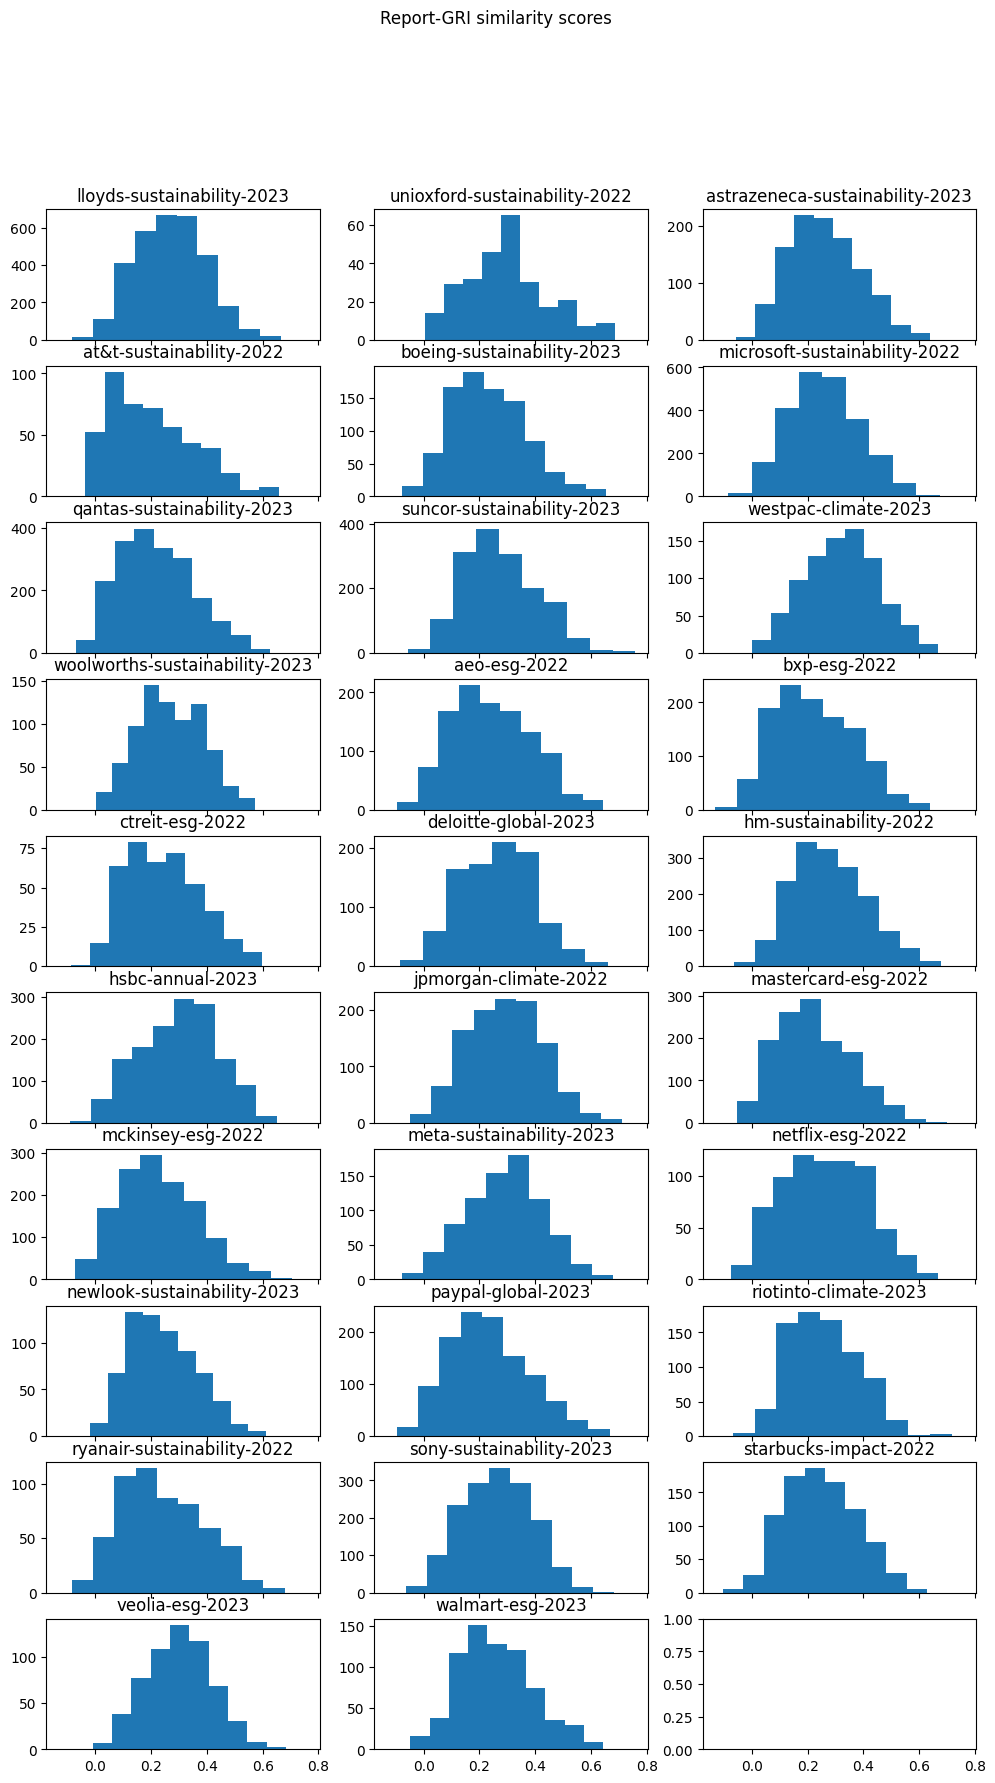

In [6]:
cols = 3
rows = 10

fig, axes = plt.subplots(rows, cols, figsize=(12,20), sharex=True)
axes = axes.flatten()

for index, key in enumerate(gri_sim_scores):
    # new subplot with (i + 1)-th index laying on a grid
    ax = axes[index]
    # plt.subplot(rows, cols, index + 1) 
    ax.hist(gri_sim_scores[key], bins=10,)
    ax.set_title(key)

fig.suptitle("Report-GRI similarity scores")
plt.show()


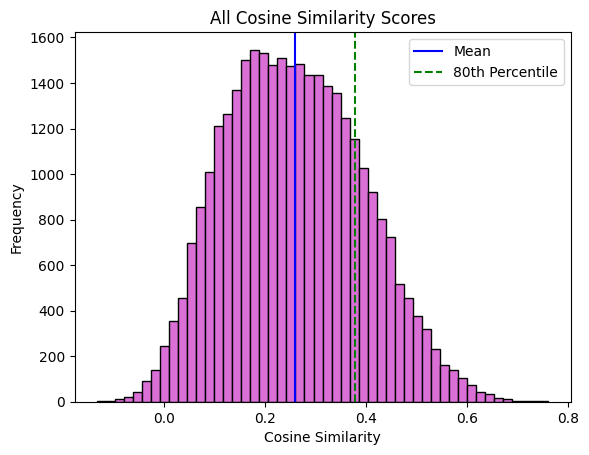

In [85]:
import numpy as np
all_scores = np.concatenate(list(gri_sim_scores.values()))
plt.hist(all_scores, bins=50, color='orchid', edgecolor='black')
plt.axvline(np.mean(all_scores), color='blue', label='Mean')
plt.axvline(np.percentile(all_scores, 80), color='green', linestyle='--', label='80th Percentile')
plt.title("All Cosine Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def get_rank_dist(new_rankings, dataset_name):
    plot_ranks = []
    for ranks in new_rankings.values():
        for gri, score in ranks:
            plot_ranks.append(score)
    n, bins, patches = plt.hist(plot_ranks)
    plt.title(dataset_name)
    plt.show()

In [13]:
new_match_gris = []
for ind, report in enumerate(gri_matches):
    report_match = {}
    report_name = "-".join(list(report.keys())[0].split("-")[:3])
    for passage_idx, match_arr in report.items():
        # new_match_arr = []
        # new_match_gris = []
        for match in match_arr[:3]:
            if match[1] > 0.4:
                # new_match_arr.append(match)
                new_match_gris.append({"section": passage_idx, "gri_idx": match[0], "sim_score": match[1], "gri_desc": gri_indicators[match[0]]})
    #     if len(new_match_arr) > 0:
    #         report_match[passage_idx] = {"gri": new_match_gris, "sim_scores": new_match_arr}
    # with open(f"match/{report_name}.json", "w") as f:
    #     json.dump(report_match, f)

In [17]:
len(new_match_gris)

3756